In [2]:
import openeo
from openeo.rest.mlmodel import MlModel
from openeo.extra.spectral_indices.spectral_indices import compute_and_rescale_indices
from openeo.processes import if_, is_nodata, array_concat, array_create
import geopandas as gpd
import pandas as pd
import json
from pathlib import Path
import datetime
from shapely.geometry import box
import matplotlib.pyplot as plt
import rasterio
import numpy as np
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

In [3]:
mask = box(4.4, 50.2, 5.6, 51.2)
y = gpd.read_file(
    "https://artifactory.vgt.vito.be/auxdata-public/openeo/LUCAS_2018_Copernicus.gpkg",
    mask=mask,
)
y["geometry"] = y["geometry"].apply(lambda x: x.centroid)
y["LC1"] = y["LC1"].apply(lambda x: ord(x[0]) - 65)
y_train, y_test = train_test_split(y, test_size=0.25, random_state=333)

In [4]:
y_train["target"] = y_train.LC1
y_train = y_train[["target", "geometry"]]
y_test["target"] = y_test.LC1
y_test = y_test[["target", "geometry"]]
y_train

,target,geometry
104,4,POINT (5.06096 50.65388)
150,4,POINT (5.1058 50.2232)
105,1,POINT (5.0552 50.70752)
201,4,POINT (5.31993 50.89871)
30,1,POINT (4.60356 51.17385)
...,...,...
110,5,POINT (5.11171 50.70987)
179,4,POINT (5.24289 51.09367)
163,1,POINT (5.23653 50.31891)
205,1,POINT (5.42265 50.72273)


In [5]:
c = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

Authenticated using refresh token.


In [6]:
def connection():
    return c


# create sentinel-2 10-daily composite


def sentinel2_composite(
    start_date,
    end_date,
    connection_provider,
    provider,
    index_dict=None,
    s2_list=[],
    processing_opts={},
    sampling=False,
    stepsize=10,
    overlap=10,
    reducer="median",
    luc=False,
    cloud_procedure="sen2cor",
):
    """
    Compute a cloud-masked, gap-filled, Sentinel-2 datacube, composited at 10-daily intervals.
    """
    # define the temporal extent for the Sentinel-2 data
    temp_ext_s2 = [start_date.isoformat(), end_date.isoformat()]

    # properties to filter the data
    props = {"eo:cloud_cover": lambda v: v <= 80}

    bands = ["B03", "B04", "B05", "B06", "B07", "B08", "B11", "B12"]
    idx_list = ["NDVI", "NDMI", "NDRE1", "NDRE2", "NDRE5"]

    # establish a connection to the data source
    c = connection_provider()
    scl = c.load_collection(
        "SENTINEL2_L2A", temporal_extent=temp_ext_s2, bands="SCL", properties=props
    )
    cloud_mask = scl.process(
        "to_scl_dilation_mask",
        data=scl,
        kernel1_size=17, kernel2_size=77,
        mask1_values=[2, 4, 5, 6, 7],
        mask2_values=[3, 8, 9, 10, 11],
        erosion_kernel_size=3
    )
    s2 = c.load_collection(
        "SENTINEL2_L2A", temporal_extent=temp_ext_s2, bands=bands, properties=props
    )
    # apply cloud masking
    s2 = s2.mask(cloud_mask)

    # compute the spectral indices
    indices = compute_and_rescale_indices(s2, index_dict)

    # combine the original bands with the computed indices
    combined = s2.merge_cubes(indices)

    # filter the combined collection to include the desired bands and indices
    result_indices = combined.filter_bands(s2_list + idx_list)

    # aggregate the filtered collection to 10-daily intervals using the specified reducer
    idx_dekad = result_indices.aggregate_temporal_period("dekad", reducer="median")

    # apply linear interpolation to fill any temporal gaps
    idx_dekad = idx_dekad.apply_dimension(
        dimension="t", process="array_interpolate_linear"
    )
    return idx_dekad


# create Sentinel-1 12 day composite
def sentinel1_composite(
    start_date,
    end_date,
    connection_provider=connection,
    provider="Terrascope",
    processing_opts={},
    relativeOrbit=None,
    orbitDirection="ascending",
    sampling=False,
    stepsize=12,
    overlap=6,
    reducer="mean",
):
    """
    Compute a Sentinel-1 datacube, composited at 12-day intervals.
    """

    c = connection_provider()
    # define the temporal extent for the Sentinel-1 data
    temp_ext_s1 = [start_date.isoformat(), end_date.isoformat()]

    s1 = c.load_collection(
        "SENTINEL1_GRD", temporal_extent=temp_ext_s1, bands=["VH", "VV"], properties=[
        openeo.collection_property("sat:orbit_state") == orbitDirection,
    ]
    )

    # apply SAR backscatter processing to the collection
    s1 = s1.sar_backscatter(coefficient="sigma0-ellipsoid")

    # apply band-wise processing to create a ratio and log-transformed bands
    s1 = s1.apply_dimension(
        dimension="bands",
        process=lambda x: array_create(
            [
                30.0 * x[0] / x[1],  # Ratio of VH to VV
                30.0 + 10.0 * x[0].log(base=10),  # Log-transformed VH
                30.0 + 10.0 * x[1].log(base=10),  # Log-transformed VV
            ]
        ),
    )

    s1 = s1.rename_labels("bands", ["ratio"] + s1.metadata.band_names)

    # scale to int16
    s1 = s1.linear_scale_range(0, 30, 0, 30000)

    # aggregate the collection to 12-day intervals using the specified reducer
    s1_dekad = s1.aggregate_temporal_period(period="dekad", reducer="median")

    # apply linear interpolation to fill any temporal gaps
    s1_dekad = s1_dekad.apply_dimension(
        dimension="t", process="array_interpolate_linear"
    )
    return s1_dekad


def compute_statistics_fill_nan(base_features, start_date, end_date, stepsize):
    """
    Computes statistics over a datacube.
    For correct statistics, the datacube needs to be preprocessed to
    contain observation at equitemporal intervals, without nodata values.

    """

    def computeStats(input_timeseries, sample_stepsize, offset):
        tsteps = list(
            [
                input_timeseries.array_element(offset + sample_stepsize * index)
                for index in range(0, 6)
            ]
        )
        tsteps[1] = if_(is_nodata(tsteps[1]), tsteps[2], tsteps[1])
        tsteps[4] = if_(is_nodata(tsteps[4]), tsteps[3], tsteps[4])
        tsteps[0] = if_(is_nodata(tsteps[0]), tsteps[1], tsteps[0])
        tsteps[5] = if_(is_nodata(tsteps[5]), tsteps[4], tsteps[5])
        return array_concat(
            array_concat(
                input_timeseries.quantiles(probabilities=[0.25, 0.5, 0.75]),
                input_timeseries.sd(),
            ),
            tsteps,
        )

    tot_samples = (end_date - start_date).days // stepsize
    nr_tsteps = 6
    sample_stepsize = tot_samples // nr_tsteps
    offset = int(sample_stepsize / 2 + (tot_samples % nr_tsteps) / 2)

    features = base_features.apply_dimension(
        dimension="t",
        target_dimension="bands",
        process=lambda x: computeStats(x, sample_stepsize, offset),
    )

    tstep_labels = [
        "t" + str(offset + sample_stepsize * index) for index in range(0, 6)
    ]
    all_bands = [
        band + "_" + stat
        for band in base_features.metadata.band_names
        for stat in ["p25", "p50", "p75", "sd"] + tstep_labels
    ]
    features = features.rename_labels("bands", all_bands)
    return features


def load_lc_features(
    provider,
    feature_raster,
    start_date,
    end_date,
    stepsize_s2=10,
    stepsize_s1=12,
    processing_opts={},
    index_dict=None,
    connection_provider=connection,
):

    if not index_dict:
        idx_list = ["NDVI", "NDMI", "NDRE1", "NDRE2", "NDRE5"]
        s2_list = ["B06", "B12"]
        index_dict = {idx: [-1, 1] for idx in idx_list}
        index_dict["ANIR"] = [0, 1]

    final_index_dict = {
        "collection": {"input_range": [0, 8000], "output_range": [0, 30000]},
        "indices": {
            index: {"input_range": index_dict[index], "output_range": [0, 30000]}
            for index in index_dict
        },
    }

    idx_dekad = sentinel2_composite(
        start_date,
        end_date,
        connection_provider,
        provider,
        final_index_dict,
        s2_list,
        processing_opts=processing_opts,
        sampling=True,
        stepsize=stepsize_s2,
        luc=True,
    )
    idx_features = compute_statistics_fill_nan(
        idx_dekad, start_date, end_date, stepsize=stepsize_s2
    )

    s1_dekad = sentinel1_composite(
        start_date,
        end_date,
        connection_provider,
        provider,
        processing_opts=processing_opts,
        sampling=True,
        stepsize=stepsize_s1,
    )
    s1_features = compute_statistics_fill_nan(
        s1_dekad, start_date, end_date, stepsize=stepsize_s1
    )

    features = idx_features.merge_cubes(s1_features)

    return features, features.metadata.band_names

In [7]:
# Load land cover features from the specified source and time period
features, feature_list = load_lc_features(
    "cdse", "both", datetime.date(2022, 3, 1), datetime.date(2022, 10, 31)
)
X = features.aggregate_spatial(json.loads(y_train.to_json()), reducer="mean")

# Train a random forest classifier using the aggregated features
ml_model = X.fit_class_random_forest(
    target=json.loads(y_train.to_json()), num_trees=200
)
model = ml_model.save_ml_model()

In [8]:
job_options = {
    "executor-memory": "2G",
    "python-memory": "2500m",
}

In [9]:
training_job = model.create_job(
    title="Training-job Dynamic LC", job_options=job_options
)
training_job.start_and_wait()

0:00:00 Job 'j-250329122917464c82f8a8fd110941e8': send 'start'
0:00:14 Job 'j-250329122917464c82f8a8fd110941e8': created (progress 0%)
0:00:20 Job 'j-250329122917464c82f8a8fd110941e8': created (progress 0%)
0:00:27 Job 'j-250329122917464c82f8a8fd110941e8': created (progress 0%)
0:00:36 Job 'j-250329122917464c82f8a8fd110941e8': created (progress 0%)
0:00:46 Job 'j-250329122917464c82f8a8fd110941e8': created (progress 0%)
0:00:59 Job 'j-250329122917464c82f8a8fd110941e8': created (progress 0%)
0:01:15 Job 'j-250329122917464c82f8a8fd110941e8': running (progress N/A)
0:01:35 Job 'j-250329122917464c82f8a8fd110941e8': running (progress N/A)
0:01:59 Job 'j-250329122917464c82f8a8fd110941e8': running (progress N/A)
0:02:30 Job 'j-250329122917464c82f8a8fd110941e8': running (progress N/A)
0:03:08 Job 'j-250329122917464c82f8a8fd110941e8': running (progress N/A)
0:03:55 Job 'j-250329122917464c82f8a8fd110941e8': running (progress N/A)
0:04:54 Job 'j-250329122917464c82f8a8fd110941e8': running (progress

<BatchJob job_id='j-250329122917464c82f8a8fd110941e8'>

In [10]:
print(
    f""" The total openEO credits consumed when executing training the model is {training_job.describe()['costs']} credits."""
)

 The total openEO credits consumed when executing training the model is 90 credits.


In [11]:
results = training_job.get_results()
results.download_files()

[WindowsPath('c:/Users/anshi/Desktop/randomforest.model.tar.gz'),
 WindowsPath('c:/Users/anshi/Desktop/job-results.json')]

In [12]:
links = results.get_metadata()["links"]
ml_model_metadata_url = [
    link for link in links if "ml_model_metadata.json" in link["href"]
][0]["href"]
print(ml_model_metadata_url)

https://openeo.dataspace.copernicus.eu/openeo/1.2/jobs/j-250329122917464c82f8a8fd110941e8/results/items/ZjViYzFmYjItZTEyNS00NzNjLWE3MjAtNmEzMjgwNjQ2YmEy/7a6633178b285d2908e2c743bb333955/ml_model_metadata.json?expires=1743858945


In [13]:
model = MlModel.load_ml_model(connection=c, id=ml_model_metadata_url)

In [14]:
base_path = Path.cwd() / "results" / "testarea"
validation_path = base_path / "validation"
validation_path.mkdir(parents=True, exist_ok=True)

y_test.to_file(filename=str(validation_path / "y_test.geojson"), driver="GeoJSON")
cube = features
cube

In [ ]:
predicted = (
    cube.predict_random_forest(model=model, dimension="bands")
    .linear_scale_range(0, 255, 0, 255)
    .aggregate_spatial(json.loads(y_test.to_json()), reducer="mean")
)  # " "
test_job = predicted.execute_batch(
    out_format="CSV", title="dynamic land cover prediction"
)
test_job.get_results().download_files()

0:00:00 Job 'j-2503291315494ade863de4d586e8bce0': send 'start'
0:00:16 Job 'j-2503291315494ade863de4d586e8bce0': created (progress 0%)
0:00:22 Job 'j-2503291315494ade863de4d586e8bce0': running (progress N/A)
0:00:29 Job 'j-2503291315494ade863de4d586e8bce0': running (progress N/A)
0:00:37 Job 'j-2503291315494ade863de4d586e8bce0': running (progress N/A)
0:00:47 Job 'j-2503291315494ade863de4d586e8bce0': running (progress N/A)
0:01:00 Job 'j-2503291315494ade863de4d586e8bce0': running (progress N/A)
0:01:17 Job 'j-2503291315494ade863de4d586e8bce0': running (progress N/A)
0:01:36 Job 'j-2503291315494ade863de4d586e8bce0': running (progress N/A)
0:02:00 Job 'j-2503291315494ade863de4d586e8bce0': running (progress N/A)
0:02:31 Job 'j-2503291315494ade863de4d586e8bce0': running (progress N/A)
0:03:09 Job 'j-2503291315494ade863de4d586e8bce0': running (progress N/A)
0:03:56 Job 'j-2503291315494ade863de4d586e8bce0': running (progress N/A)
0:04:54 Job 'j-2503291315494ade863de4d586e8bce0': running (pro

[WindowsPath('c:/Users/anshi/Desktop/timeseries.csv'),
 WindowsPath('c:/Users/anshi/Desktop/job-results.json')]

In [16]:
df = pd.read_csv("timeseries.csv")
df.index = df.feature_index
df = df.sort_index()
df.columns = ["feature_index", "predicted"]

gdf = gpd.read_file(validation_path / "y_test.geojson")

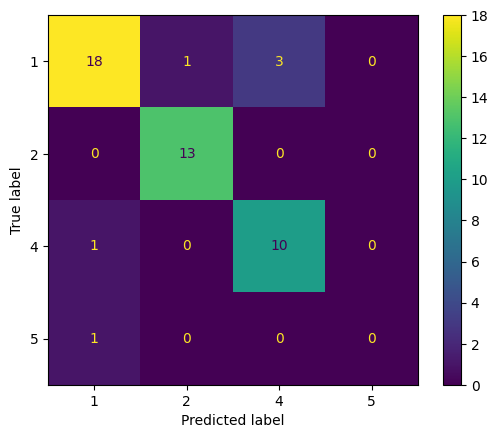

In [17]:
gdf["predicted"] = df.predicted#.astype(int)
gdf = gdf.dropna()
ConfusionMatrixDisplay.from_predictions(gdf["target"], gdf["predicted"])



In [18]:
accuracy_score(gdf["target"], gdf["predicted"])

0.8723404255319149

In [19]:
features, feature_list = load_lc_features(
    "cdse",
    "both",
    datetime.date(2022, 3, 1),
    datetime.date(2022, 10, 31),
    processing_opts=dict(tile_size=256),
)

cube = features.filter_bbox({"west": 5.1, "east": 5.4, "south": 50.6, "north": 50.8})
predicted = cube.predict_random_forest(
    model=model, dimension="bands"
).linear_scale_range(0, 255, 0, 255)
inf_job = predicted.execute_batch(out_format="GTiff",title="Generate landcover map", filename_prefix="dynamic_landcover_map")
inf_job.get_results().download_files()

0:00:00 Job 'j-25032913513945e8927f6229495acd4b': send 'start'
0:00:14 Job 'j-25032913513945e8927f6229495acd4b': created (progress 0%)
0:00:19 Job 'j-25032913513945e8927f6229495acd4b': created (progress 0%)
0:00:25 Job 'j-25032913513945e8927f6229495acd4b': created (progress 0%)
0:00:34 Job 'j-25032913513945e8927f6229495acd4b': running (progress N/A)
0:00:44 Job 'j-25032913513945e8927f6229495acd4b': running (progress N/A)
0:00:56 Job 'j-25032913513945e8927f6229495acd4b': running (progress N/A)
0:01:12 Job 'j-25032913513945e8927f6229495acd4b': running (progress N/A)
0:01:31 Job 'j-25032913513945e8927f6229495acd4b': running (progress N/A)
0:01:55 Job 'j-25032913513945e8927f6229495acd4b': running (progress N/A)
0:02:26 Job 'j-25032913513945e8927f6229495acd4b': running (progress N/A)
0:03:03 Job 'j-25032913513945e8927f6229495acd4b': running (progress N/A)
0:03:50 Job 'j-25032913513945e8927f6229495acd4b': running (progress N/A)
0:04:49 Job 'j-25032913513945e8927f6229495acd4b': running (progr

[WindowsPath('c:/Users/anshi/Desktop/dynamic_landcover_map.tif'),
 WindowsPath('c:/Users/anshi/Desktop/job-results.json')]

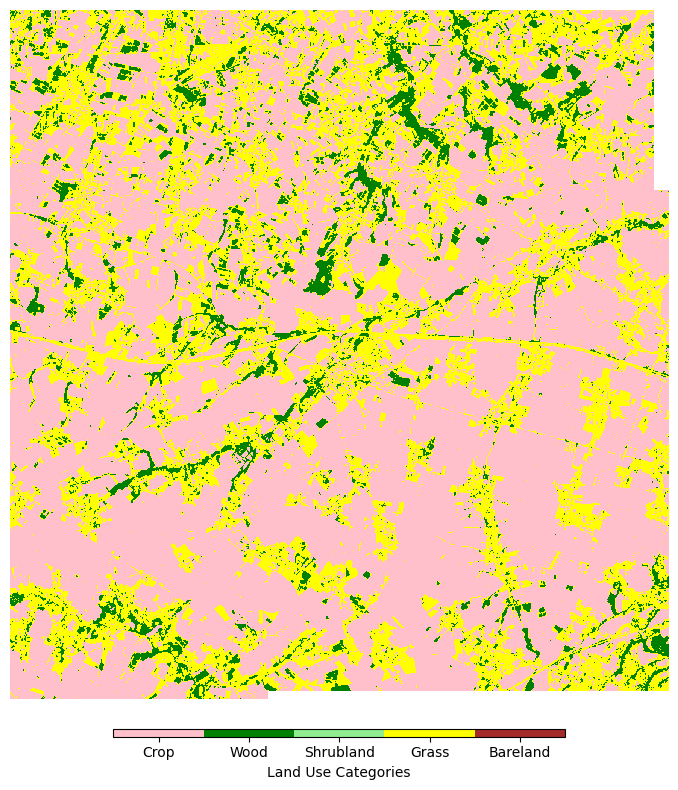

In [20]:
src = rasterio.open("dynamic_landcover_map.tif")

categories = {"Crop": 1, "Wood": 2, "Shrubland": 3, "Grass": 4, "Bareland": 5}

# Define colors for each category
colors = ["pink", "green", "lightgreen", "yellow", "brown"]

# Create a colormap based on the defined colors
cmap = ListedColormap(colors, name="custom_cmap", N=len(colors))

d = src.read(1,masked=True)

plt.figure(figsize=(8, 8))
plt.imshow(
    d, cmap=cmap, interpolation="nearest", vmin=1, vmax=len(colors) + 1
)
plt.axis("off")

# Add colorbar to show the correspondence between values and colors
cbar = plt.colorbar(
    ticks=np.arange(1.5, len(categories) + 1),
    aspect=55,
    orientation="horizontal",
    fraction=0.0113,
    pad=0.04,
)
cbar.ax.set_xticklabels(list(categories.keys()))
cbar.set_label("Land Use Categories")

plt.tight_layout()